# Handling Latitude and Longitude in the California Housing Prices Dataset

## Loading and Preparing the Data

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

housing = pd.read_csv("./data/housing.csv") 
train_set, test_set = train_test_split(housing, test_size=0.2,
    stratify=pd.cut(housing["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5]),
    random_state=42
    )

X_train = train_set.drop("median_house_value", axis=1)
y_train = train_set["median_house_value"].copy() # Store the target variable (labels)

## Understanding Geographic Coordinates in the *Dataset*

Geographic coordinates present unique challenges for machine learning models:

1. **Non-linear spatial relationships**: Housing prices don't increase or decrease monotonically with latitude or longitude. A district at latitude 37.5° isn't inherently "better" than one at 36.5°—the relationship is highly non-linear and location-dependent.

2. **Interaction effects**: Latitude and longitude only become meaningful *together*. The point (37.7749, -122.4194) is San Francisco, but neither coordinate alone carries that information. Linear models cannot capture this interaction without explicit feature engineering.

3. **Distance matters, not absolute position**: What typically matters is *proximity* to important locations (coast, city centers, employment hubs), not the raw coordinates themselves.

4. **Wrap-around and scale issues**: Longitude wraps at ±180°, and the actual ground distance represented by 1° varies with latitude.

To address these challenges, we can transform coordinates into more useful features:
- **Cluster membership**: Group districts into geographic regions
- **Distance-based features**: Measure proximity to cluster centers or points of interest
- **Similarity scores**: Use kernel functions to capture "nearness" to important locations

## K-means for Geographic Clustering


K-means is a *clustering* algorithm (unsupervised learning) that we could use to group districts into similar geographic regions. To do this, we'll use the geographic coordinates of the districts and group them into a fixed number of geographic regions.

In [ ]:
from sklearn.cluster import KMeans

# Apply K-means with k=6 (for example, to divide California into 6 regions)
kmeans = KMeans(n_clusters=6, random_state=42)
X_train['region_cluster'] = kmeans.fit_predict(X_train[['latitude', 'longitude']])
X_train[['latitude', 'longitude', 'region_cluster']].head()

,latitude,longitude,region_cluster
12655,38.52,-121.46,3
15502,33.09,-117.23,4
2908,35.37,-119.04,5
14053,32.75,-117.13,4
20496,34.28,-118.70,0


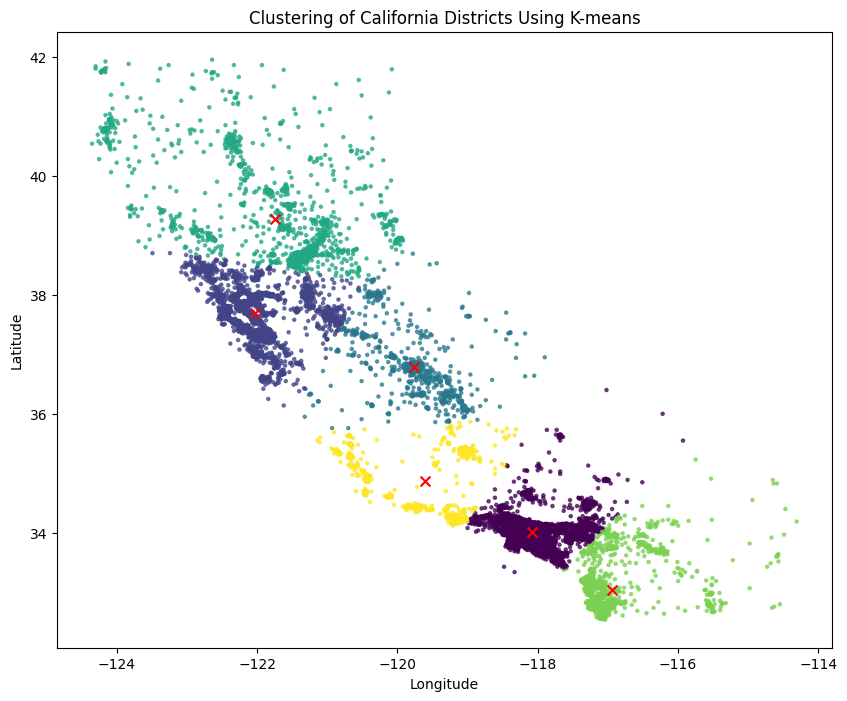

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.scatter(X_train['longitude'], X_train['latitude'], 
            c=X_train['region_cluster'], cmap='viridis', 
            s=5, alpha=0.7)
plt.scatter(kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 0], 
            c='red', s=50, marker='x')
plt.title('Clustering of California Districts Using K-means')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

We could create a custom transformer for this process:

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans

class RegionClusterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=6, random_state=42):
        self.n_clusters = n_clusters
        self.kmeans = KMeans(n_clusters=self.n_clusters, random_state=random_state)
    
    def fit(self, X, y=None):
        """
        Fits the KMeans model using the 'latitude' and 'longitude' columns.
        X is assumed to be a pandas DataFrame containing these columns.
        """
        self.kmeans.fit(X[['latitude', 'longitude']])
        return self
    
    def transform(self, X):
        """
        Transforms the DataFrame X by adding a 'region_cluster' column containing
        the cluster prediction for each record.
        """
        X_transformed = X.copy()
        X_transformed['region_cluster'] = self.kmeans.predict(X_transformed[['latitude', 'longitude']])
        return X_transformed

In [ ]:
transformer = RegionClusterTransformer(n_clusters=6, random_state=42)
transformer.fit(X_train)
housing_transformed = transformer.transform(X_train)
housing_transformed[['latitude', 'longitude', 'region_cluster']].head()

,latitude,longitude,region_cluster
12655,38.52,-121.46,3
15502,33.09,-117.23,4
2908,35.37,-119.04,5
14053,32.75,-117.13,4
20496,34.28,-118.70,0


## Adding Distance to Centroids as a Feature

However, housing prices are not only related by the cluster of districts they belong to, but districts closer to the cluster center are likely to have higher prices. Therefore, it would be useful to create a feature that captures the "proximity" to the cluster centers.

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

class DistanceClusterTransformer(BaseEstimator, TransformerMixin):
    """
    Custom transformer for grouping geographic locations using K-means.
    Expects a DataFrame with at least two columns: 'latitude' and 'longitude'.
    """
    def __init__(self, n_clusters=8, random_state=42):
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.kmeans_ = None

    def fit(self, X, y=None):
        # X is expected to be a DataFrame or array with 'latitude' and 'longitude' columns
        # Convert to array if X is a DataFrame:
        if isinstance(X, pd.DataFrame):
            coords = X[['latitude', 'longitude']].values
        else:
            coords = X[:, :2]  # assuming the first two columns are lat/lon
        self.kmeans_ = KMeans(n_clusters=self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(coords)
        return self

    def transform(self, X):
        # Ensure X is a DataFrame for easier column handling
        X_trans = X.copy() if isinstance(X, pd.DataFrame) else pd.DataFrame(X, columns=['latitude', 'longitude'])
        coords = X_trans[['latitude', 'longitude']].values
        
        # Predict the cluster label
        cluster_labels = self.kmeans_.predict(coords)
        X_trans['geo_cluster'] = cluster_labels
        
        # Calculate the distance from each point to its assigned centroid
        distances = []
        for i, point in enumerate(coords):
            centroid = self.kmeans_.cluster_centers_[cluster_labels[i]]
            distance = np.linalg.norm(point - centroid)
            distances.append(distance)
        X_trans['distance_to_centroid'] = distances
        
        return X_trans

In [ ]:
geoClusterTransformer = DistanceClusterTransformer(n_clusters=5)
geoClusterTransformer.fit(X_train[['longitude', 'latitude']])
housing_geo_clusters = geoClusterTransformer.transform(X_train[['longitude', 'latitude']])
housing_geo_clusters.head()

,longitude,latitude,geo_cluster,distance_to_centroid
12655,-121.46,38.52,3,0.810514
15502,-117.23,33.09,4,0.287789
2908,-119.04,35.37,2,0.995066
14053,-117.13,32.75,4,0.361414
20496,-118.70,34.28,0,0.614293


## Similarity with rbf_kernel

### rbf_kernel

The `rbf_kernel` function calculates the similarity between two datasets through the *radial basis function* (RBF), returning a value between 0 and 1.
For example, if we assumed that properties around 35 years old increase in value due to some particularity, we could measure the distance of each one to those that are 35 years old and assign a similarity value.

In [ ]:
from sklearn.metrics.pairwise import rbf_kernel
age_simil_35 = rbf_kernel(X_train[["housing_median_age"]], [[35]], gamma=0.1)

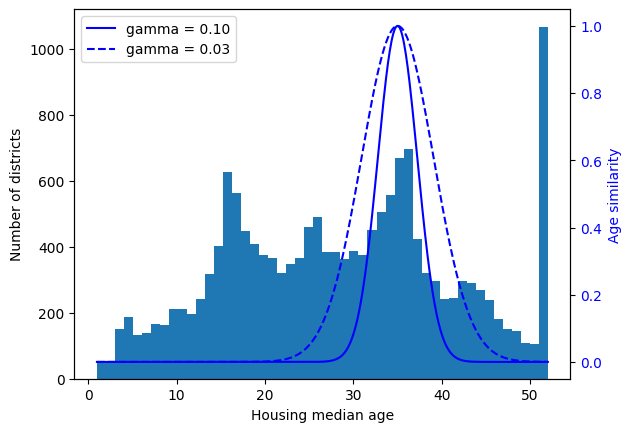

In [ ]:
ages = np.linspace(X_train["housing_median_age"].min(),
                   X_train["housing_median_age"].max(),
                   500).reshape(-1, 1)
gamma1 = 0.1
gamma2 = 0.03
rbf1 = rbf_kernel(ages, [[35]], gamma=gamma1)
rbf2 = rbf_kernel(ages, [[35]], gamma=gamma2)

fig, ax1 = plt.subplots()

ax1.set_xlabel("Housing median age")
ax1.set_ylabel("Number of districts")
ax1.hist(X_train["housing_median_age"], bins=50)

ax2 = ax1.twinx()  # create a twin axis that shares the same x-axis
color = "blue"
ax2.plot(ages, rbf1, color=color, label="gamma = 0.10")
ax2.plot(ages, rbf2, color=color, label="gamma = 0.03", linestyle="--")
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel("Age similarity", color=color)

plt.legend(loc="upper left")
plt.show()

We can see how the `gamma` value allows adjusting the similarity between the data, widening or narrowing the RBF function, which is a normal (Gaussian) distribution centered on the reference value. On the right, we can see the scale from 0 to 1 of similarity that records close to the reference value will return.

### Measuring Similarity to Centroids with rbf_kernel

Instead of distance, we can use rbf_kernel to measure the proximity of each district to the cluster centers.

In [ ]:
from sklearn.cluster import KMeans

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, n_init=10,
                              random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self  # always return self!

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

In [ ]:
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
similarities = cluster_simil.fit_transform(X_train[["latitude", "longitude"]],
                                           sample_weight=y_train)

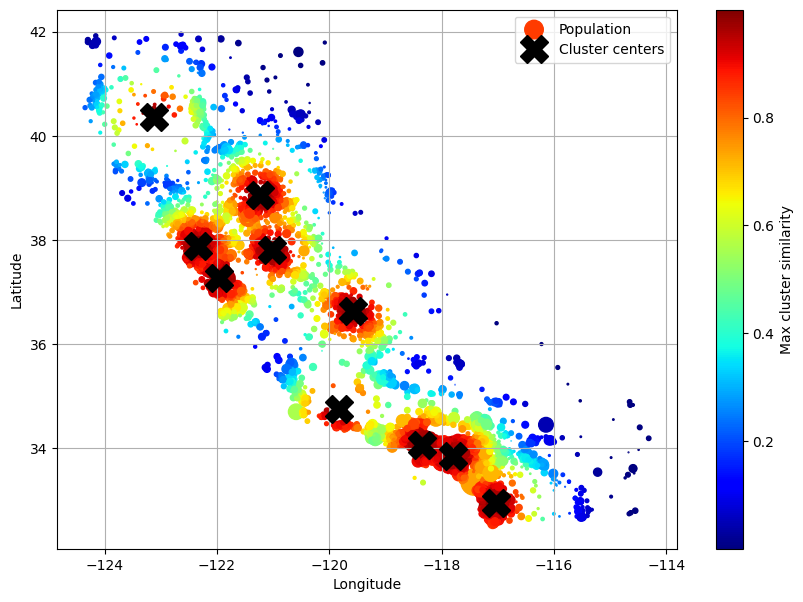

In [ ]:
housing_renamed = X_train.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (ᴜsᴅ)"})
housing_renamed["Max cluster similarity"] = similarities.max(axis=1)

housing_renamed.plot(kind="scatter", x="Longitude", y="Latitude", grid=True,
                     s=housing_renamed["Population"] / 100, label="Population",
                     c="Max cluster similarity",
                     cmap="jet", colorbar=True,
                     legend=True, sharex=False, figsize=(10, 7))
plt.plot(cluster_simil.kmeans_.cluster_centers_[:, 1],
         cluster_simil.kmeans_.cluster_centers_[:, 0],
         linestyle="", color="black", marker="X", markersize=20,
         label="Cluster centers")
plt.legend(loc="upper right")
plt.show()

## Complete Preprocessing Pipeline

At this point, we have developed all the components needed for the complete preprocessing pipeline:

- **Basic pipelines** ([e2e050](e2e050_pipelines.ipynb)): `SimpleImputer`, `StandardScaler`, `OneHotEncoder`, and `ColumnTransformer`
- **Custom transformers** ([e2e051](e2e051_custom_transformers.ipynb)): `FunctionTransformer` for feature ratios and logarithmic transformations
- **Geospatial features** (this notebook): `ClusterSimilarity` transformer using K-means and RBF kernel

These components are combined into a reusable preprocessing module at [`utils/housing_preprocessing.py`](utils/housing_preprocessing.py), which is imported by subsequent notebooks for model training and evaluation.